<a href="https://colab.research.google.com/github/roya90/KerasCampaign/blob/main/Keras_12_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Time Series Analysis

This notebook is designed to demonstrate various terms and characteristics of time series through the creation and visualization of synthetic data. Experimenting with various forecasting models on such data serves as an excellent method to enhance your understanding before you start working with actual data in later parts of the course. Let's get started!

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [27]:
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

##Generate the synthetic data

You can then use the utility functions above to generate the synthetic data. This will start at a baseline then trend upwards with a seasonal pattern every 365 steps. You will also add some noise because real world data is often noisy as well.

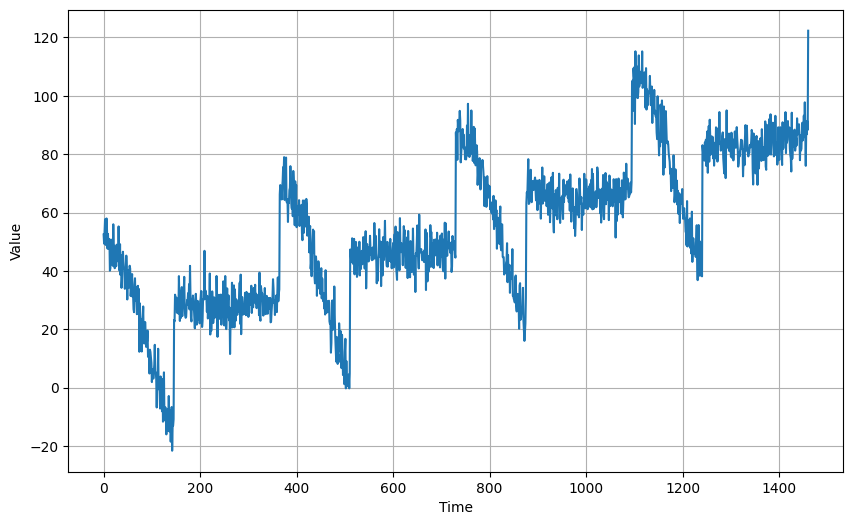

In [28]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10 * np.ones(4*365+1)
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline
series += trend(time, slope)
series += seasonality(time, period=365, amplitude=amplitude)

# # Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

# Train a Single Layer Model
## Split the Dataset
Next, divide the data into training and validation sets. Use the initial 1,000 data points for training, and allocate the remaining data for validation.

In [29]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]


You can see the training and validation data in this plot:


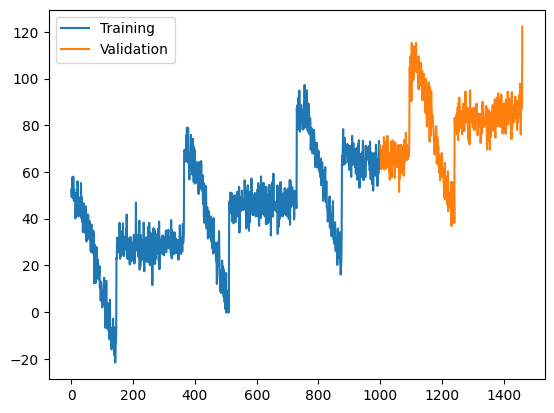

In [30]:
# Plot the train set
plt.plot(time_train, x_train)
# Plot the validation set
plt.plot(time_valid, x_valid)
plt.legend(["Training", "Validation"])

## Prepare features and labels
Next, arrange your data windows following the method demonstrated previously. It's a good practice to define your parameters in a separate cell, as this allows for easier modifications later on if required.

In [31]:
# Generate a TF Dataset from the series values
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)


for window in dataset:
  for val in window :
    print(val.numpy(), end = ", ")
  print()

0, 1, 2, 3, 4, 
1, 2, 3, 4, 5, 
2, 3, 4, 5, 6, 
3, 4, 5, 6, 7, 
4, 5, 6, 7, 8, 
5, 6, 7, 8, 9, 


In [32]:

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

for window in dataset:
  print(window.numpy())


[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [33]:
# Create tuples with features and labels
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
for features, labels  in dataset:
  print(features.numpy(),labels.numpy())

[0 1 2 3] 4
[1 2 3 4] 5
[2 3 4 5] 6
[3 4 5 6] 7
[4 5 6 7] 8
[5 6 7 8] 9


In [34]:
# Shuffle the windows
dataset = dataset.shuffle(10)
for features, labels  in dataset:
  print(features.numpy(),labels.numpy())

[3 4 5 6] 7
[4 5 6 7] 8
[0 1 2 3] 4
[5 6 7 8] 9
[1 2 3 4] 5
[2 3 4 5] 6


In [35]:
 # Create batches of windows
 dataset = dataset.batch(2).prefetch(1)
 for features, labels  in dataset:
  print('features: ', features.numpy())
  print('labels: ',labels.numpy())

features:  [[0 1 2 3]
 [5 6 7 8]]
labels:  [4 9]
features:  [[3 4 5 6]
 [2 3 4 5]]
labels:  [7 6]
features:  [[4 5 6 7]
 [1 2 3 4]]
labels:  [8 5]


In [36]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In the upcoming function, you'll find all the preprocessing steps from the previously compiled together. This modular approach makes it super convenient to reuse in your future projects.

Keep in mind the `window_size + 1` part when using `dataset.window()`. The `+1` signifies that the next data point is used as the label. So, if you're using the first 20 points as features, the 21st point becomes the label.

In [37]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

Now you can generate the dataset windows from the train set.

In [38]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

You can double-check the output to ensure the function is performing correctly. The code below employs the `take()` method from the `tf.data.Dataset` API to fetch a single batch. It will display various properties of this batch, like the data type and the shape of the elements. Ideally, you should see a 2-element tuple `(feature, label)` where the shapes correspond to the batch and window sizes you set earlier, which are 32 and 20, respectively, by default.

In [39]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


## Build and compile the model
Next up, let's construct the single-layer neural network. You'll be creating a one-unit Dense layer as illustrated below. Assign this layer to a variable named l0. This way, you can easily check out the final weights later on by using the `get_weights()` method.

In [40]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.3979685 ],
       [-0.04099697],
       [-0.5273509 ],
       [ 0.12963182],
       [-0.24966508],
       [ 0.46032774],
       [-0.45094052],
       [ 0.3631022 ],
       [-0.06419602],
       [-0.07885814],
       [ 0.06032401],
       [-0.06395084],
       [-0.462332  ],
       [-0.18391415],
       [ 0.47332984],
       [-0.19725317],
       [ 0.21761298],
       [ 0.05608678],
       [ 0.17933673],
       [-0.21418753]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


You will set mean squared error (mse) as the loss function and use stochastic gradient descent (SGD) to optimize the weights during training.



In [41]:

# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

Train the Model
Now you can proceed to train your model. You will feed in the prepared data windows and run the training for 100 epochs.

In [42]:
# Train the model
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 22ms/step - loss: 1672.6289
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 178.3309
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 105.5980
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 98.9708
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 97.9448
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 93.4368
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 90.8615
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 87.5846
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 85.5073
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 85.9121
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 81.4148
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 79.4043
Epoch 13/100
31/31 [


You can see the final weights by again calling the get_weights() method.

In [43]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.06695953],
       [ 0.05387684],
       [-0.04138928],
       [ 0.04516492],
       [-0.02657622],
       [ 0.10091664],
       [-0.1108057 ],
       [ 0.07429085],
       [-0.04033981],
       [ 0.02528811],
       [ 0.00567747],
       [ 0.01300678],
       [-0.10975733],
       [ 0.03022806],
       [ 0.10149574],
       [ 0.01090106],
       [ 0.05057666],
       [ 0.16834061],
       [ 0.31037217],
       [ 0.39951852]], dtype=float32), array([0.01878222], dtype=float32)]


## Model Prediction
Now that the training is complete, it's time to evaluate your model's performance. To generate a prediction, pass a batch of data windows through the model. If you're slicing a window from the original series array, remember to add a batch dimension before feeding it to the model. This can be achieved by indexing with `np.newaxis` or by utilizing the `np.expand_dims()` method.

In [44]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 107ms/step
model prediction: [[42.617065]]


To calculate the metrics, you'll need to generate predictions for your validation set using your model. This set covers data points from index 1000 to 1460 in the entire series. You'll have to program the steps to create these predictions. The cell below shows one method to do this.

In essence, it involves feeding your model the entire series in chunks of 20 points and compiling the outcomes in a forecast list. Afterward, you'll extract the segment corresponding to your validation set.

The slicing index is set as `split_time - window_size` because the forecast list is shorter than the series by 20 points, which is the window size. Since the window size is 20, the forecast list's first data point represents the prediction for the time at index 20. Predictions for indices 0 to 19 aren't possible, as they fall below the window size. Therefore, using `split_time - window_size` as your slice index aligns the forecast points with those in the validation set.

A heads-up: This process might take some time. In the next two labs, you'll explore faster prediction methods. If you have ideas already, feel free to experiment with them after finishing this lab.

In [45]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 22ms/step
length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


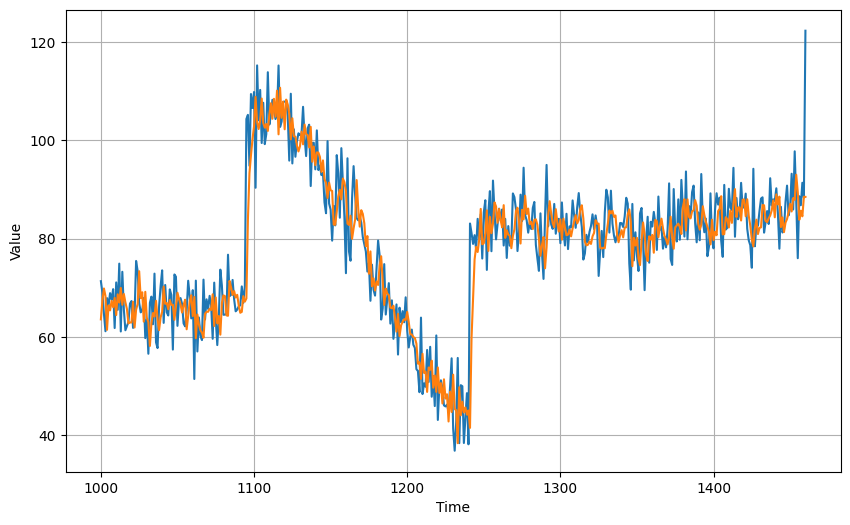

In [46]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

# Build a Three Dense Layers Model
In this exercise, you'll be working with three dense layers, as detailed below. Naturally, this will lead to a significant increase in the number of trainable parameters. Indeed, the model summary will reveal that it has over ten times the parameters compared to the previous lab.

In [47]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


##Train the Model

Next, compile and train the model using the same settings as before. Pay attention to how the loss decreases – this is something you'll circle back to later in this lab.

In [48]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [49]:
# Train the model
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 727.9320
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 106.6219
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 87.3989
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 83.0976
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 78.9208
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 75.5034
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 72.5973
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 70.5318
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 67.2945
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 65.3770
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 63.0570
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 61.7507
Epoch 13/100
31/31 [===

You can proceed to generate some predictions and visualize them as you did previously. Keep in mind, with a deeper network, the prediction process might be slower, so it's wise to avoid unnecessary computations.

Recall from the previous exersice, the model used the entire series data for predictions, resulting in a forecast list of 1,441 points, from which you sliced the 461 points corresponding to the validation set using `forecast = forecast[split_time - window_size:]`.

To speed up the process, consider generating only the necessary 461 points from the start. This approach eliminates the need to predict points that you'll eventually discard. The code below accomplishes this by extracting the relevant points from the original series before invoking the `predict()` method. Consequently, all predictions will directly correspond to the validation set, and the `for-loop` will iterate only 461 times instead of 1,441.

In the next lab, you'll discover an even more efficient method for generating these predictions.

1/1 [==============================] - 0s 23ms/step


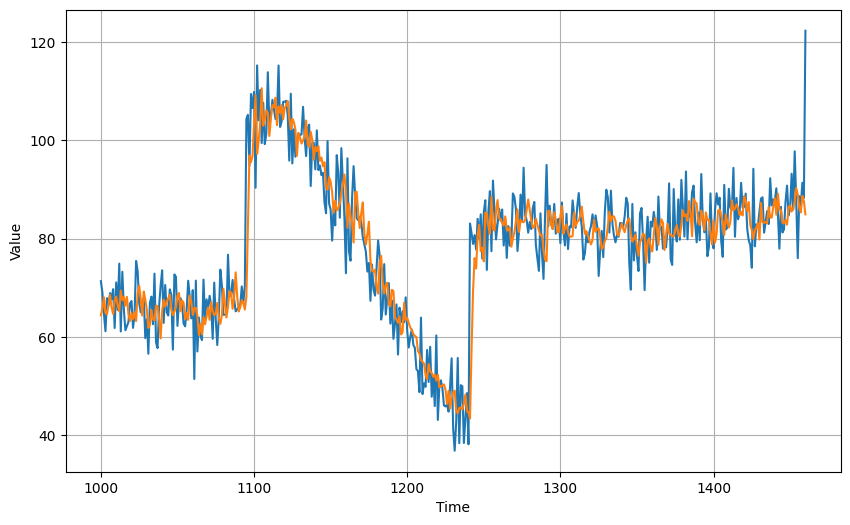

In [50]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]));

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze();

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then get the MSE and MAE for reference.

In [51]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

43.71885
4.8079777


## Tune the learning rate

The training progressed smoothly with the initial learning rate you selected (1e-6), but it's not certain if this is the optimal setting for this specific model. While it may not seem crucial for a simple model, dedicating time to fine-tune the learning rate can significantly enhance training outcomes, especially in more complex models. This section will guide you on how to do that.

To start, you'll reconstruct the same model architecture you've recently worked with.

In [52]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

Up next, you're going to set up a learning rate scheduler callback. This tool enables you to adjust the learning rate dynamically based on the epoch number throughout the training process. As illustrated below, you'll use a `lambda` function to define the learning rate's value. It starts at `1e-8` at epoch `0` and increases following the scale of `10**(epoch / 20)` as training progresses.

In [53]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))


Next, you'll compile the model. You don't need to specify the `learning_rate` argument of the optimizer before compiling. You can simply stick with the default (which is 0.01 for SGD) and let the learning rate scheduler handle its dynamic adjustment.

In [54]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)


Incorporate the `lr_schedule` callback into the `callbacks` parameter of the `fit()` method. When you execute the training below, observe the learning rate for each epoch, indicated by 'lr' in the console output. You'll see it increasing as anticipated, following the pattern set by the lambda function you implemented.

In [55]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 2833.2009 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 2517.6455 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 2191.7666 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 1879.3828 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 1579.6149 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 1293.8105 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 1025.7869 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 780.7817 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 571.1017 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 404.9432 - lr: 2.8184e-08
Ep

Next step is to plot the results of the training. You will visualize the loss at each value of the learning rate.



(1e-08, 0.001, 0.0, 300.0)

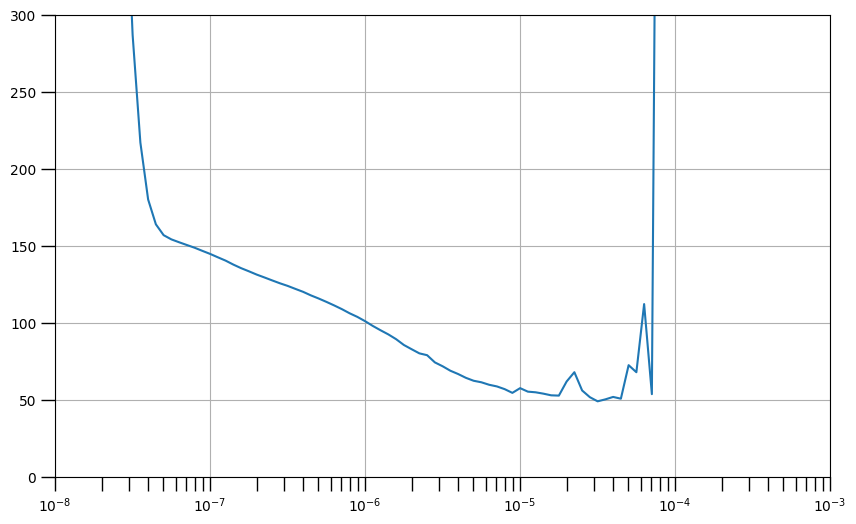

In [56]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

The graph presented above illustrates the range of learning rates that result in decreasing losses (identified by a downward slope) and those that lead to unstable training (marked by jagged edges and an upward trend). Generally, it's advisable to select a learning rate situated on the downward slope, indicating that the network is learning effectively and remains stable. Opting for a rate near the graph's minimum point can expedite the convergence to that specific loss value, as you'll see in the subsequent cells.

To begin with, you'll initialize the same model architecture once more.

In [57]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

You will then set the optimizer with a learning rate close to the minimum. It is set to `4e-6` initially but feel free to change based on your results.

In [58]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

In [59]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 503.2975
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 108.1951
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 87.6389
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 71.8708
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 64.3710
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 60.6033
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 58.8380
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 55.5280
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 55.7271
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 52.9666
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 51.8531
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 52.0586
Epoch 13/100
31/31 [===

You can visualize the loss values by extracting them from the History object, which is returned by the `fit()` method. As evident from the plot, the model's loss continues to trend downward even after the training concludes.

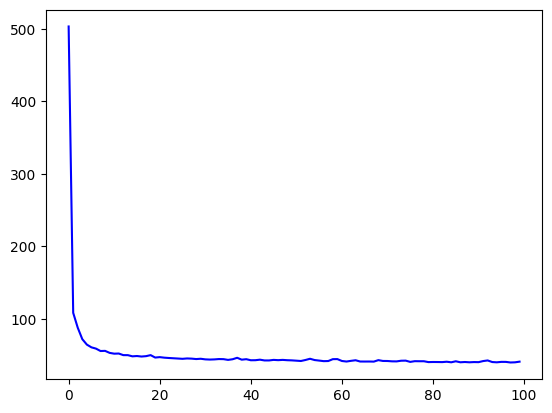

In [60]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

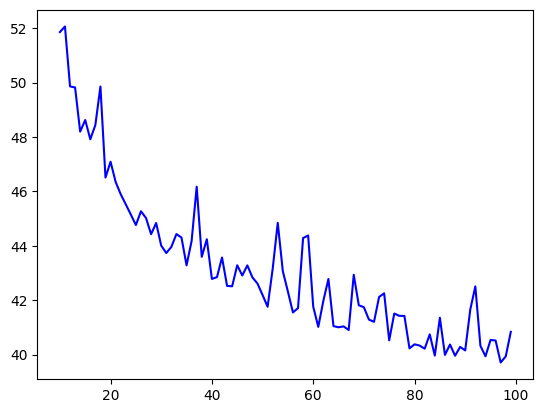

In [61]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

1/1 [==============================] - 0s 35ms/step


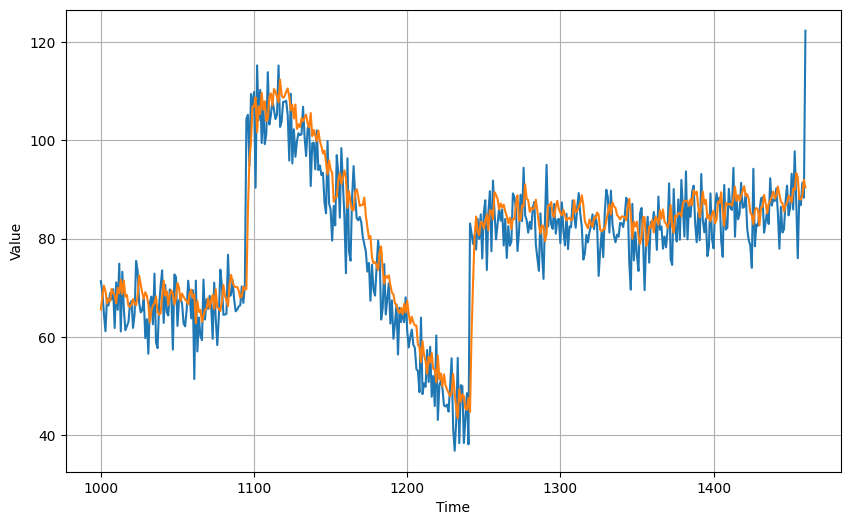

In [62]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

Lastly, you can calculate the metrics, and you should expect to see results similar to those of the baseline model. If the performance is significantly poorer, it may indicate that the model has overfitted. In such a case, you can employ techniques you're familiar with to mitigate this, such as adding dropout layers.

In [63]:

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

47.2066
5.2924666


# Recurrent Neural Networks

## Build the Model
Your model primarily consists of `SimpleRNN` layers. As discussed in the lectures, this type of RNN loops its output back into the input. In your model, you will stack two such layers, necessitating the `return_sequences` parameter to be set to True for the first layer.

As per the documentation, SimpleRNN layers require a 3-dimensional tensor input, shaped as `[batch, timesteps, feature]`. Consequently, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`, mapping the 20 data points in the window to 20 timesteps in the RNN. This reshaping can be done in a separate cell, but you can also integrate it within the model using Lambda layers. Observe the first layer in the example below. It includes a lambda function that adds a dimension to the input's last axis, achieving the needed transformation. For the `input_shape`, you have options: either specify `None` for more flexibility with the number of timesteps, as shown in the lecture video, or set it to `window_size` to match the expected size of your data windows.

Typically, a Dense layer output suffices, as seen in previous labs. However, to facilitate training, you might scale the output to approximate your labels' scale. This depends on the activation functions in your model. SimpleRNN defaults to `tanh`, which outputs in the range `[-1,1]`. Use another Lambda() layer to scale the output by 100 before the layer weights are adjusted. After this lab, you're encouraged to experiment by removing this scaling layer to observe the impact on results.

In [64]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_10 (Dense)            (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 4s 14ms/step - loss: 125.7639 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 117.0652 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 106.6124 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 96.0084 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 85.9618 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 12ms/step - loss: 76.5152 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 67.4120 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 58.4209 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 12ms/step - loss: 49.2998 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 12ms/step - loss: 40.1517 - lr: 2.8184e-08
Epoch 

You can visualize the results and pick an optimal learning rate.



(1e-08, 0.001, 0.0, 50.0)

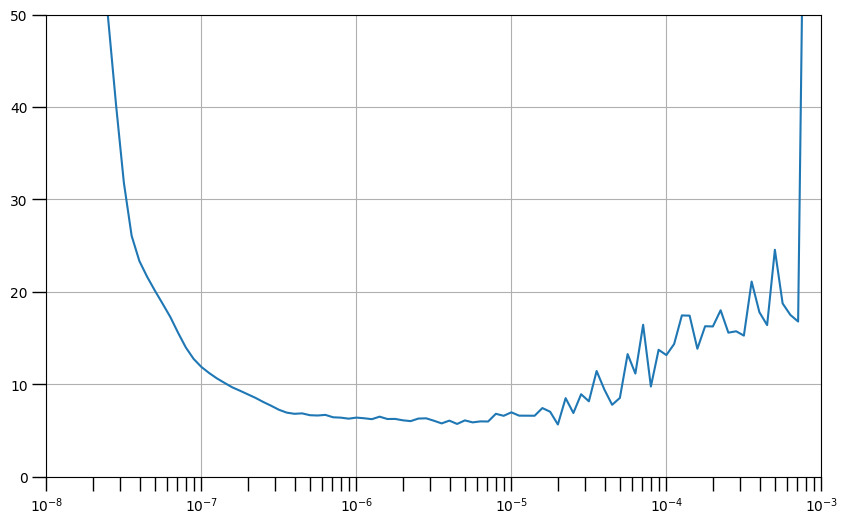

In [66]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

## Train the Model

In [67]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 12ms/step - loss: 15.9626 - mae: 16.4540
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 9.5549 - mae: 10.0377
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 9.1380 - mae: 9.6236
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 9.3586 - mae: 9.8447
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 8.6666 - mae: 9.1463
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 8.3385 - mae: 8.8171
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 8.2797 - mae: 8.7560
Epoch 8/100
31/31 [==============================] - 1s 12ms/step - loss: 8.0944 - mae: 8.5741
Epoch 9/100
31/31 [==============================] - 0s 12ms/step - loss: 8.0513 - mae: 8.5327
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 8.2376 - mae: 8.7189
Epoch 11/100
31/31 [==========================

## Model Prediction


Now, let's proceed to generate predictions for the time range of the validation set using the model. This model is significantly larger than the ones you've previously worked with. Due to the sequential processing characteristic of RNNs, where inputs are processed through a series of time steps rather than in parallel, the prediction process might be somewhat slower. You'll notice this when running the code from the previous lab, which is expected to take around a minute to complete.


1/1 [==============================] - 0s 29ms/step


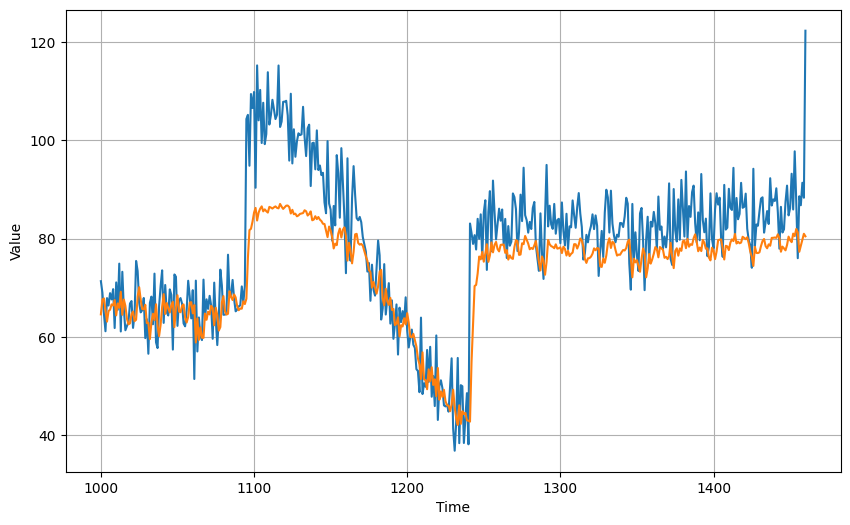

In [68]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

To make this step more efficient, take advantage of TensorFlow models' ability to process batches. Rather than using the above for-loop, which processes one window at a time, you can input an entire batch of windows for the model to process simultaneously.

The function outlined below accomplishes this. It closely resembles the `windowed_dataset(`) function, but crucially, it doesn't shuffle the windows. This is important for maintaining the correct sequence of outputs, allowing for accurate comparison with the validation set.

In [69]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 0s 11ms/step


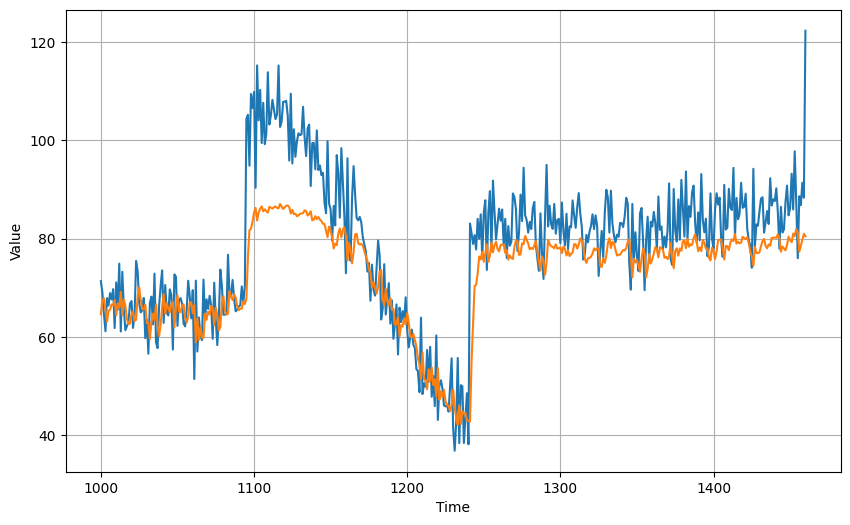

In [70]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [71]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

93.50953
7.216994


# LSTM

## Build the Model

In this lab, as previously mentioned, you'll be replacing `SimpleRNN` layers with `LSTM`. Additionally, the `LSTM` is configured as `bidirectional` in the example below, but you're encouraged to modify this later and observe the resulting changes. LSTMs have a more intricate internal architecture compared to SimpleRNNs, featuring a cell state that enhances their ability to remember sequences more effectively. This increased complexity leads to a larger set of parameters to train, which will become apparent when you view the model summary below.

In [72]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

## Tune the Learning Rate

In [73]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 10s 36ms/step - loss: 55.0734 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 35ms/step - loss: 53.8381 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 35ms/step - loss: 52.3582 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 2s 63ms/step - loss: 50.6920 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 36ms/step - loss: 48.8223 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 35ms/step - loss: 46.7163 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 35ms/step - loss: 44.3420 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 35ms/step - loss: 41.6757 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 35ms/step - loss: 38.6798 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 36ms/step - loss: 35.3142 - lr: 2.8184e-08
Epoch 11

(1e-08, 0.001, 0.0, 30.0)

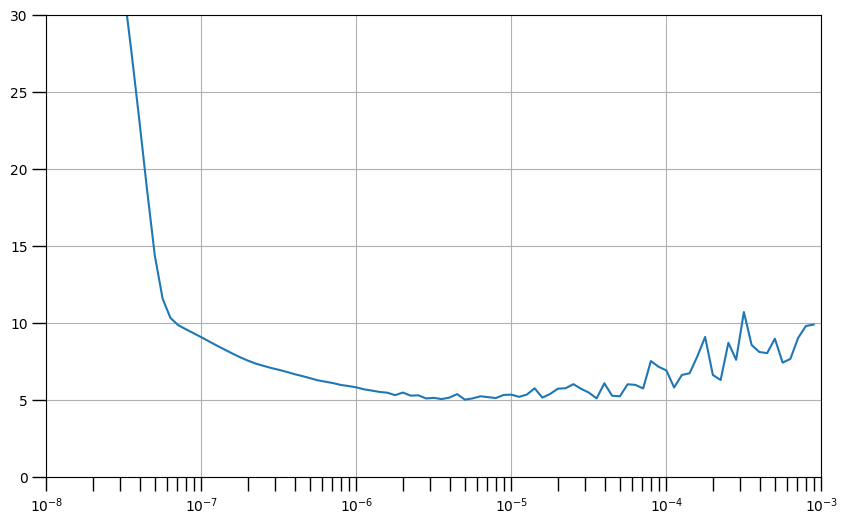

In [74]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model
Next, you're ready to train the model using the learning rate you've selected.

Here's a tip: If you're experimenting with various iterations of a model, consider using the `clear_session()` method to free up memory occupied by Keras. This method is included in the first line of the code below to help streamline your process.

In [75]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 11s 51ms/step - loss: 18.1142 - mae: 18.6068
Epoch 2/100
31/31 [==============================] - 2s 51ms/step - loss: 11.4230 - mae: 11.9132
Epoch 3/100
31/31 [==============================] - 2s 50ms/step - loss: 9.7020 - mae: 10.1871
Epoch 4/100
31/31 [==============================] - 2s 50ms/step - loss: 8.7787 - mae: 9.2631
Epoch 5/100
31/31 [==============================] - 2s 51ms/step - loss: 8.1495 - mae: 8.6327
Epoch 6/100
31/31 [==============================] - 2s 51ms/step - loss: 7.7554 - mae: 8.2391
Epoch 7/100
31/31 [==============================] - 2s 70ms/step - loss: 7.4817 - mae: 7.9635
Epoch 8/100
31/31 [==============================] - 2s 51ms/step - loss: 7.2262 - mae: 7.7070
Epoch 9/100
31/31 [==============================] - 2s 50ms/step - loss: 7.0197 - mae: 7.5010
Epoch 10/100
31/31 [==============================] - 2s 50ms/step - loss: 6.9400 - mae: 7.4196
Epoch 11/100
31/31 [=======================

## Model Prediction

Next, you'll create batches of windows specifically for generating predictions that correspond with the validation set.


In [76]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 2s 19ms/step


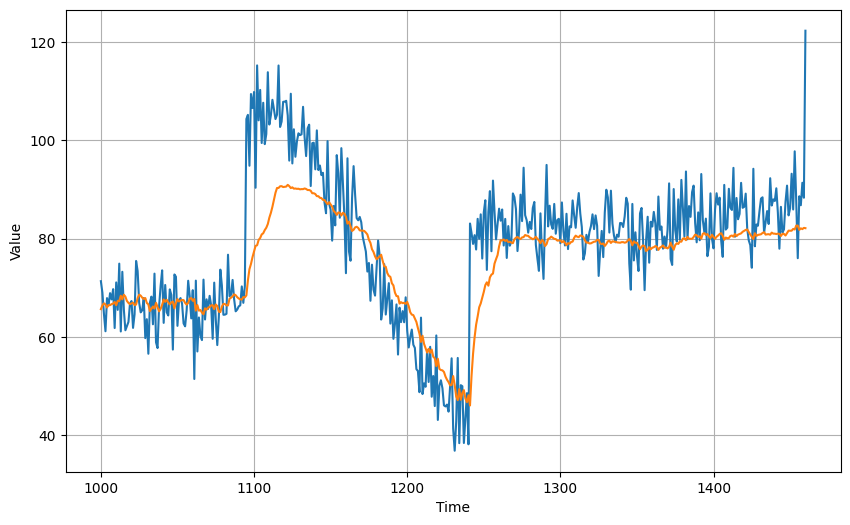

In [77]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [78]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

87.373116
6.7352605
